# Relacion PCA y Autoencoder
La practica se desarrollará sobre la base de datos MNIST

In [2]:
from sklearn import decomposition
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import backend as K
import itertools
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.backend import clear_session
%matplotlib inline
mnist = pd.read_csv("data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
X_train, X_test, y_train, y_test = X[:300], X[300:], y[:300], y[300:]
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]

In [3]:
print ("dimension de las imagenes y las clases", X.shape, y.shape)
print ("dimension del dataset, train:", X_train.shape, y_train_oh.shape,'test:',  X_test.shape, y_test_oh.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)
dimension del dataset, train: (300, 784) (300, 10) test: (1200, 784) (1200, 10)


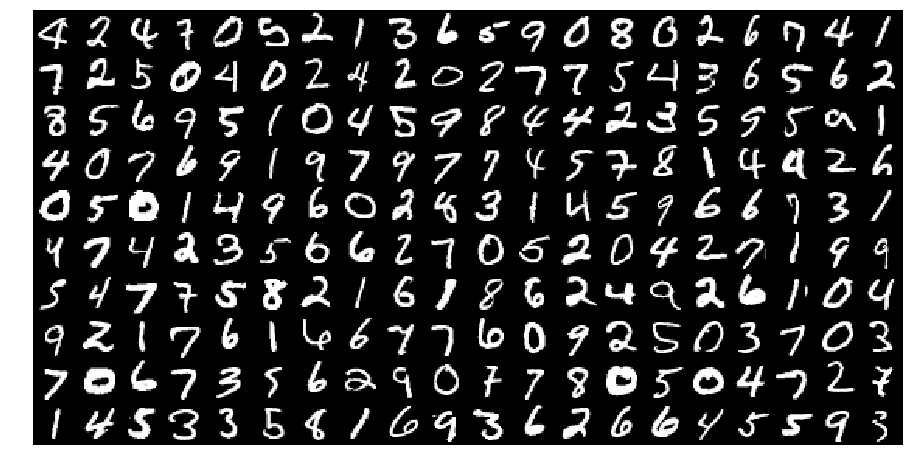

In [5]:
def show_linearized_images_sample(X, n_images=200, permutation=True):
    plt.figure(figsize=(18,8))
    Xp = np.random.permutation(X) if permutation else X
    img =  np.rollaxis(np.rollaxis(Xp[:n_images].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.axis("off")
show_linearized_images_sample(X)


## Se haran 3 experimentos: una capa oculta, mas capas, y la capa mas larga. Con variaciones en las funciones de activacion.


### 1. Una capa oculta, funcion de activacion linear.

In [6]:
def get_model_B(input_dim, code_size):
    model= Sequential()
    model.add(Dense(code_size, activation='linear', input_dim=input_dim))
    model.add(Dense(input_dim, activation='linear'))    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.reset_states()    
    return model

In [7]:
model = get_model_B(input_dim=X.shape[1], code_size=24)
model.fit(X_train, X_train, epochs=100, batch_size=32)
pca = decomposition.PCA(n_components=24)
pca.fit(X_train)
X1 = pca.transform(X_test)

Epoch 1/100
300/300 [==============================] - 1s 4ms/step - loss: 0.1138
Epoch 2/100
300/300 [==============================] - 0s 120us/step - loss: 0.0904
Epoch 3/100
300/300 [==============================] - 0s 107us/step - loss: 0.0715
Epoch 4/100
300/300 [==============================] - 0s 120us/step - loss: 0.0648
Epoch 5/100
300/300 [==============================] - 0s 120us/step - loss: 0.0622
Epoch 6/100
300/300 [==============================] - 0s 120us/step - loss: 0.0595
Epoch 7/100
300/300 [==============================] - ETA: 0s - loss: 0.061 - 0s 107us/step - loss: 0.0566
Epoch 8/100
300/300 [==============================] - 0s 120us/step - loss: 0.0538
Epoch 9/100
300/300 [==============================] - 0s 133us/step - loss: 0.0512
Epoch 10/100
300/300 [==============================] - 0s 120us/step - loss: 0.0488
Epoch 11/100
300/300 [==============================] - 0s 107us/step - loss: 0.0466
Epoch 12/100
300/300 [==============================

Epoch 97/100
300/300 [==============================] - 0s 120us/step - loss: 0.0195
Epoch 98/100
300/300 [==============================] - 0s 120us/step - loss: 0.0195
Epoch 99/100
300/300 [==============================] - 0s 120us/step - loss: 0.0195
Epoch 100/100
300/300 [==============================] - 0s 120us/step - loss: 0.0195


In [5]:
print("Dimension despues de aplciar PCA: ", X1.shape,"Antes:",X_train.shape)

Dimension despues de aplciar PCA:  (1200, 24) Antes: (300, 784)


Text(0.5, 1.0, 'Encoder')

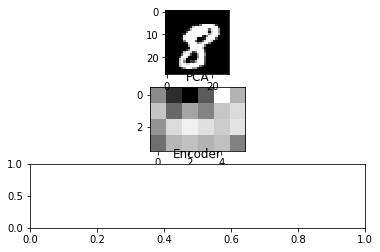

In [6]:
plt.subplot(3,1,2)
plt.title('PCA')
plt.imshow(X1[10,:].reshape(4,-1), interpolation="nearest", cmap = plt.cm.Greys_r)
plt.subplot(3,1,1)
plt.imshow(X[10,:].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
plt.subplot(3,1,3)
plt.title('Encoder')


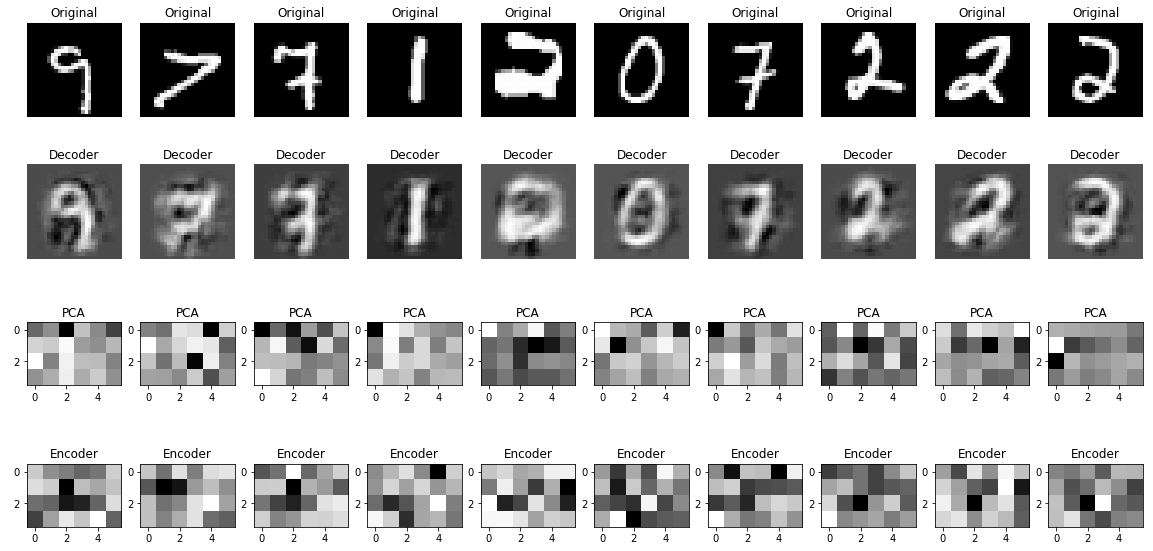

In [7]:
plt.figure(figsize=(20,10))
X_sample = np.random.permutation(X_test)[:10]
X_pred   = model.predict(X_sample)
l1_output = K.function([model.input, K.learning_phase()], [model.layers[0].output])
X_sample_encoded = l1_output([X_sample,1.])[0]
X_sample_pca=pca.transform(X_sample)
for i in range(len(X_sample)):
    plt.subplot(4,len(X_sample),i+1)
    plt.title('Original')
    plt.imshow(X_sample[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(4,len(X_sample),len(X_sample)+i+1)
    plt.title('Decoder')
    plt.imshow(X_pred[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(4,len(X_sample),len(X_sample)*2+i+1)    
    plt.title('PCA')
    plt.imshow(X_sample_pca[i].reshape(4,-1), cmap=plt.cm.Greys_r)    
    plt.subplot(4,len(X_sample),len(X_sample)*3+i+1)
    plt.title('Encoder')
    plt.imshow(X_sample_encoded[i].reshape(4,-1), cmap=plt.cm.Greys_r)
    
    

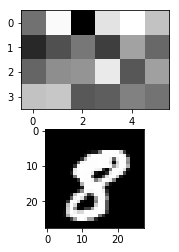

In [51]:
plt.subplot(2,1,1)
plt.imshow(X1[10,:].reshape(4,-1), interpolation="nearest", cmap = plt.cm.Greys_r)
plt.subplot(2,1,2)
plt.imshow(X[10,:].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    

In [61]:

def get_model_A(input_dim, hidden_size, code_size):
    clear_session()
    model = Sequential()
    model.add(Dense(hidden_size, activation='linear', input_dim=input_dim))
    model.add(Dense(code_size, activation='linear'))
    model.add(Dense(hidden_size, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.reset_states()
    return model


In [70]:
def get_model_B(input_dim, code_size):
    model= Sequential()
    model.add(Dense(code_size, activation='linear', input_dim=input_dim))
    model.add(Dense(input_dim, activation='linear'))    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.reset_states()
    
    return model

In [62]:

model = get_model_A(input_dim=X.shape[1], hidden_size=256, code_size=24)
model.fit(X_train, X_train, epochs=100, batch_size=32)

Epoch 1/100
300/300 [==============================] - 0s 1ms/step - loss: 0.1090
Epoch 2/100
300/300 [==============================] - 0s 400us/step - loss: 0.0671
Epoch 3/100
300/300 [==============================] - 0s 440us/step - loss: 0.0555
Epoch 4/100
300/300 [==============================] - 0s 413us/step - loss: 0.0453
Epoch 5/100
300/300 [==============================] - 0s 400us/step - loss: 0.0398
Epoch 6/100
300/300 [==============================] - 0s 400us/step - loss: 0.0360
Epoch 7/100
300/300 [==============================] - 0s 400us/step - loss: 0.0334
Epoch 8/100
300/300 [==============================] - 0s 400us/step - loss: 0.0310
Epoch 9/100
300/300 [==============================] - 0s 405us/step - loss: 0.0290
Epoch 10/100
300/300 [==============================] - 0s 413us/step - loss: 0.0275
Epoch 11/100
300/300 [==============================] - 0s 400us/step - loss: 0.0262
Epoch 12/100
300/300 [==============================] - 0s 400us/step - loss

In [71]:

model = get_model_B(input_dim=X.shape[1],code_size=24)
model.fit(X_train, X_train, epochs=100, batch_size=32)

Epoch 1/100
300/300 [==============================] - 0s 2ms/step - loss: 1001.7083
Epoch 2/100
300/300 [==============================] - 0s 173us/step - loss: 992.0147
Epoch 3/100
300/300 [==============================] - 0s 160us/step - loss: 1082.4133
Epoch 4/100
300/300 [==============================] - 0s 160us/step - loss: 992.9426
Epoch 5/100
300/300 [==============================] - 0s 160us/step - loss: 1016.1448
Epoch 6/100
300/300 [==============================] - 0s 173us/step - loss: 969.7473
Epoch 7/100
300/300 [==============================] - 0s 160us/step - loss: 1106.1336
Epoch 8/100
300/300 [==============================] - 0s 160us/step - loss: 997.6574
Epoch 9/100
300/300 [==============================] - 0s 163us/step - loss: 988.8509
Epoch 10/100
300/300 [==============================] - 0s 147us/step - loss: 960.6244
Epoch 11/100
300/300 [==============================] - 0s 160us/step - loss: 935.9403
Epoch 12/100
300/300 [============================

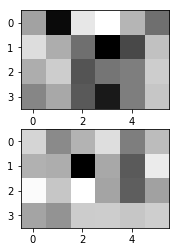

In [74]:


#X_sample = np.random.permutation(X_test)[:10]
X_sample = (X_test)[:10]
X_pred   = model.predict(X_sample)
l1_output = K.function([model.input, K.learning_phase()], [model.layers[0].output])
X_sample_encoded = l1_output([X_sample,1.])[0]

plt.subplot(2,1,1)
plt.imshow(X1[6,:].reshape(4,-1), interpolation="nearest", cmap = plt.cm.Greys_r)
plt.subplot(2,1,2)

plt.imshow(X_sample_encoded[6,:].reshape(4,-1), cmap = plt.cm.Greys_r)
#plt.imshow(X_sample_encoded[i].reshape(10,10), cmap=plt.cm.Greys_r)

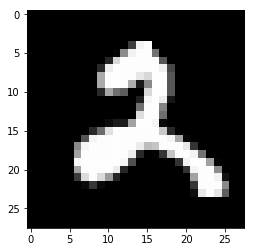

In [73]:
X_sample.shape
plt.imshow(X_sample[6,:].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)